In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 771ms/step - loss: 0.1125
Average validation loss: 0.1269868016242981
4/4 [==============================] - 8s 788ms/step - loss: 0.1125 - val_loss: 0.1270
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 796ms/step - loss: 0.0815 - val_loss: 0.1270
Average validation loss: 0.15435585379600525
4/4 [==============================] - 12s 819ms/step - loss: 0.0815 - val_loss: 0.1407
Epoch 3/10
4/4 [==============================] - 15s 774ms/step - loss: 0.0627 - val_loss: 0.1407
Average validation loss: 0.15875717997550964
4/4 [==============================] - 15s 789ms/step - loss: 0.0627 - val_loss: 0.1467
Epoch 4/10
4/4 [==============================] - 18s 759ms/step - loss: 0.0508 - val_loss: 0.1467
Average validation loss: 0.15210315585136414
4/4 [==============================] - 18s 775m

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 769ms/step - loss: 0.0032
Average validation loss: 0.38575416803359985
8/8 [==============================] - 6s 785ms/step - loss: 0.0032 - val_loss: 0.3858
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 763ms/step - loss: 0.0030 - val_loss: 0.3858
Average validation loss: 0.24823230504989624
8/8 [==============================] - 13s 776ms/step - loss: 0.0030 - val_loss: 0.3170
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 19s 763ms/step - loss: 0.0029 - val_loss: 0.3170
Average validation loss: 0.21704436838626862
8/8 [==============================] - 19s 779ms/step - loss: 0.0029 - val_loss: 0.2837
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 710ms/step - loss: 0.0032
Average validation loss: 0.36248892545700073
12/12 [==============================] - 9s 721ms/step - loss: 0.0032 - val_loss: 0.3625
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 716ms/step - loss: 0.0033 - val_loss: 0.3625
Average validation loss: 0.17638477186361948
12/12 [==============================] - 18s 730ms/step - loss: 0.0033 - val_loss: 0.2694
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 706ms/step - loss: 0.0033 - val_loss: 0.2694
Average validation loss: 0.13294588526089987
12/12 [==============================] - 26s 718ms/step - loss: 0.0033 - val_loss: 0.2239
Saved model weights to 'c:\Use

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 722ms/step - loss: 0.0036
Average validation loss: 0.07755364291369915
16/16 [==============================] - 12s 735ms/step - loss: 0.0036 - val_loss: 0.0776
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 721ms/step - loss: 0.0038 - val_loss: 0.0776
Average validation loss: 0.1398071050643921
16/16 [==============================] - 24s 734ms/step - loss: 0.0038 - val_loss: 0.1087
Epoch 3/10
16/16 [==============================] - 35s 718ms/step - loss: 0.0038 - val_loss: 0.1087
Average validation loss: 0.13925424590706825
16/16 [==============================] - 35s 729ms/step - loss: 0.0038 - val_loss: 0.1189
Epoch 4/10
16/16 [==============================] - 47s 741ms/step - loss: 0.0038 - val_loss: 0.1189
Average validation loss: 0.09981861151754856
16/16 [=======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 709ms/step - loss: 0.0027
Average validation loss: 0.13115956485271454
20/20 [==============================] - 14s 722ms/step - loss: 0.0027 - val_loss: 0.1312
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 710ms/step - loss: 0.0027 - val_loss: 0.1312
Average validation loss: 0.13896584510803223
20/20 [==============================] - 29s 723ms/step - loss: 0.0027 - val_loss: 0.1351
Epoch 3/10
20/20 [==============================] - 43s 709ms/step - loss: 0.0025 - val_loss: 0.1351
Average validation loss: 0.12052808701992035
20/20 [==============================] - 43s 720ms/step - loss: 0.0025 - val_loss: 0.1302
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_25.pth'.
Epoch 4/10
20/20 [==========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 709ms/step - loss: 0.0020
Average validation loss: 0.13794640451669693
24/24 [==============================] - 17s 720ms/step - loss: 0.0020 - val_loss: 0.1379
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 716ms/step - loss: 0.0019 - val_loss: 0.1379
Average validation loss: 0.13833018143971762
24/24 [==============================] - 35s 727ms/step - loss: 0.0019 - val_loss: 0.1381
Epoch 3/10
24/24 [==============================] - 52s 705ms/step - loss: 0.0019 - val_loss: 0.1381
Average validation loss: 0.1580371136466662
24/24 [==============================] - 52s 716ms/step - loss: 0.0019 - val_loss: 0.1448
Epoch 4/10
24/24 [==============================] - 69s 707ms/step - loss: 0.0019 - val_loss: 0.1448
Average validation loss: 0.15162872026364008
24/24 [=======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 726ms/step - loss: 0.0026
Average validation loss: 0.14743020981550217
40/40 [==============================] - 29s 737ms/step - loss: 0.0026 - val_loss: 0.1474
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 723ms/step - loss: 0.0024 - val_loss: 0.1474
Average validation loss: 0.15022011399269103
40/40 [==============================] - 59s 735ms/step - loss: 0.0024 - val_loss: 0.1488
Epoch 3/10
40/40 [==============================] - 88s 719ms/step - loss: 0.0023 - val_loss: 0.1488
Average validation loss: 0.13653847724199294
40/40 [==============================] - 88s 731ms/step - loss: 0.0023 - val_loss: 0.1447
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_50.pth'.
Epoch 4/10
40/40 [==========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 726ms/step - loss: 0.0019
Average validation loss: 0.1686528672774633
48/48 [==============================] - 35s 738ms/step - loss: 0.0019 - val_loss: 0.1687
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 722ms/step - loss: 0.0017 - val_loss: 0.1687
Average validation loss: 0.1632410610715548
48/48 [==============================] - 71s 735ms/step - loss: 0.0017 - val_loss: 0.1659
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 105s 716ms/step - loss: 0.0015 - val_loss: 0.1659
Average validation loss: 0.16172387326757112
48/48 [==============================] - 106s 729ms/step - loss: 0.0015 - val_loss: 0.1645
Saved model weights to 'c:\U

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 725ms/step - loss: 0.0022
Average validation loss: 0.1507666813475745
56/56 [==============================] - 41s 737ms/step - loss: 0.0022 - val_loss: 0.1508
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 718ms/step - loss: 0.0021 - val_loss: 0.1508
Average validation loss: 0.18663043954542705
56/56 [==============================] - 82s 730ms/step - loss: 0.0021 - val_loss: 0.1687
Epoch 3/10
56/56 [==============================] - 123s 723ms/step - loss: 0.0020 - val_loss: 0.1687
Average validation loss: 0.18005951387541635
56/56 [==============================] - 123s 735ms/step - loss: 0.0020 - val_loss: 0.1725
Epoch 4/10
56/56 [==============================] - 164s 731ms/step - loss: 0.0019 - val_loss: 0.1725
Average validation loss: 0.1559929954154151
56/56 [=====================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 697ms/step - loss: 0.0016
Average validation loss: 0.16378761176019907
64/64 [==============================] - 45s 708ms/step - loss: 0.0016 - val_loss: 0.1638
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 698ms/step - loss: 0.0014 - val_loss: 0.1638
Average validation loss: 0.17159792967140675
64/64 [==============================] - 91s 709ms/step - loss: 0.0014 - val_loss: 0.1677
Epoch 3/10
64/64 [==============================] - 136s 698ms/step - loss: 0.0013 - val_loss: 0.1677
Average validation loss: 0.15874731540679932
64/64 [==============================] - 136s 709ms/step - loss: 0.0013 - val_loss: 0.1647
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_80.pth'.
Epoch 4/10
64/64 [========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 696ms/step - loss: 0.0014
Average validation loss: 0.1584637463092804
72/72 [==============================] - 51s 707ms/step - loss: 0.0014 - val_loss: 0.1585
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 700ms/step - loss: 0.0012 - val_loss: 0.1585
Average validation loss: 0.16954799162016976
72/72 [==============================] - 102s 711ms/step - loss: 0.0012 - val_loss: 0.1640
Epoch 3/10
72/72 [==============================] - 153s 699ms/step - loss: 0.0011 - val_loss: 0.1640
Average validation loss: 0.17286599427461624
72/72 [==============================] - 153s 711ms/step - loss: 0.0011 - val_loss: 0.1670
Epoch 4/10
72/72 [==============================] - 204s 698ms/step - loss: 9.7365e-04 - val_loss: 0.1670
Average validation loss: 0.16762694054179722
72/72 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 62s 772ms/step - loss: 0.0012
Average validation loss: 0.17029883936047555
80/80 [==============================] - 63s 784ms/step - loss: 0.0012 - val_loss: 0.1703
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 124s 767ms/step - loss: 9.7610e-04 - val_loss: 0.1703
Average validation loss: 0.17660204470157623
80/80 [==============================] - 125s 779ms/step - loss: 9.7610e-04 - val_loss: 0.1735
Epoch 3/10
80/80 [==============================] - 187s 767ms/step - loss: 9.3387e-04 - val_loss: 0.1735
Average validation loss: 0.17575783133506775
80/80 [==============================] - 188s 779ms/step - loss: 9.3387e-04 - val_loss: 0.1742
Epoch 4/10
80/80 [==============================] - 249s 772ms/step - loss: 8.5058e-04 - val_loss: 0.1742
Average validation loss: 0.14678357914090157
80/

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 75s 778ms/step - loss: 0.0015
Average validation loss: 0.15668154073258242
96/96 [==============================] - 76s 791ms/step - loss: 0.0015 - val_loss: 0.1567
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 151s 775ms/step - loss: 0.0012 - val_loss: 0.1567
Average validation loss: 0.1655744481831789
96/96 [==============================] - 152s 789ms/step - loss: 0.0012 - val_loss: 0.1611
Epoch 3/10
96/96 [==============================] - 226s 777ms/step - loss: 0.0010 - val_loss: 0.1611
Average validation loss: 0.1743382556984822
96/96 [==============================] - 228s 790ms/step - loss: 0.0010 - val_loss: 0.1655
Epoch 4/10
96/96 [==============================] - 302s 775ms/step - loss: 9.5696e-04 - val_loss: 0.1655
Average validation loss: 0.16603981765607992
96/96 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 710ms/step - loss: 0.0013
Average validation loss: 0.17129237552483875
120/120 [==============================] - 87s 721ms/step - loss: 0.0013 - val_loss: 0.1713
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 172s 709ms/step - loss: 0.0011 - val_loss: 0.1713
Average validation loss: 0.1612680604060491
120/120 [==============================] - 173s 720ms/step - loss: 0.0011 - val_loss: 0.1663
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 259s 713ms/step - loss: 9.4258e-04 - val_loss: 0.1663
Average validation loss: 0.1684006263812383
120/120 [==============================] - 260s 724ms/step - loss: 9.4258e-04 - val_loss: 0.1670
Epoc

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 717ms/step - loss: 9.8988e-04
Average validation loss: 0.1676255708767308
144/144 [==============================] - 105s 729ms/step - loss: 9.8988e-04 - val_loss: 0.1676
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 714ms/step - loss: 8.2067e-04 - val_loss: 0.1676
Average validation loss: 0.16710046637389395
144/144 [==============================] - 209s 725ms/step - loss: 8.2067e-04 - val_loss: 0.1674
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 314s 722ms/step - loss: 7.3172e-04 - val_loss: 0.1674
Average validation loss: 0.16094976953334278
144/144 [==============================] - 315s 733ms/step - loss: 7.3172e-04 - va

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 716ms/step - loss: 8.0366e-04
Average validation loss: 0.15451681353151797
160/160 [==============================] - 116s 727ms/step - loss: 8.0366e-04 - val_loss: 0.1545
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 714ms/step - loss: 6.4456e-04 - val_loss: 0.1545
Average validation loss: 0.15817487984895706
160/160 [==============================] - 233s 725ms/step - loss: 6.4456e-04 - val_loss: 0.1563
Epoch 3/10
160/160 [==============================] - 347s 716ms/step - loss: 5.8214e-04 - val_loss: 0.1563
Average validation loss: 0.16346933953464032
160/160 [==============================] - 349s 727ms/step - loss: 5.8214e-04 - val_loss: 0.1587
Epoch 4/10
160/160 [==============================] - 463s 716ms/step - loss: 5.3916e-04 - val_loss: 0.1587
Average validation loss:

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 704ms/step - loss: 0.0013
Average validation loss: 0.16532735884189606
200/200 [==============================] - 143s 716ms/step - loss: 0.0013 - val_loss: 0.1653
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 284s 705ms/step - loss: 0.0011 - val_loss: 0.1653
Average validation loss: 0.16668240934610368
200/200 [==============================] - 286s 716ms/step - loss: 0.0011 - val_loss: 0.1660
Epoch 3/10
200/200 [==============================] - 428s 706ms/step - loss: 9.5786e-04 - val_loss: 0.1660
Average validation loss: 0.17611235469579697
200/200 [==============================] - 430s 718ms/step - loss: 9.5786e-04 - val_loss: 0.1694
Epoch 4/10
200/200 [==============================] - 571s 706ms/step - loss: 8.6726e-04 - val_loss: 0.1694
Average validation loss: 0.1697874978184

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:46 - loss: 1.8292e-04

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 716ms/step - loss: 8.9424e-04
Average validation loss: 0.1601838357746601
240/240 [==============================] - 175s 727ms/step - loss: 8.9424e-04 - val_loss: 0.1602
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 344s 704ms/step - loss: 7.6764e-04 - val_loss: 0.1602
Average validation loss: 0.15603732590874037
240/240 [==============================] - 346s 716ms/step - loss: 7.6764e-04 - val_loss: 0.1581
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 515s 703ms/step - loss: 6.8940e-04 - val_loss: 0.1581
Average validation loss: 0.15983166421453157
240/240 [==============================] - 518s 714ms/step - loss: 6.8940e-04 - va

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.21287474602460862, 0.15995726361870766, 0.13653631940484046, 0.14563725773245095, 0.1464466554224491, 0.14788839414715765, 0.15295182654261588, 0.188508628445367, 0.16187790751457215, 0.16573947133496403, 0.16867649303542243, 0.1694410941004753, 0.16538717024028302, 0.1662659467856089, 0.16387474651137984, 0.16283587865531446, 0.16642238937020298, 0.16437076745927331]
std_val_losses =  [0.11854792096612428, 0.04888290697291541, 0.04417721164493652, 0.026395420513066533, 0.01649126529953366, 0.008285702221579922, 0.007466981096870624, 0.0745823987238019, 0.012469101411834334, 0.008382409209548785, 0.007095606995969431, 0.009932645807311454, 0.005813445469901207, 0.005234858599070551, 0.004968899135607069, 0.005824407560649352, 0.006478038239616189, 0.003971247764507556]


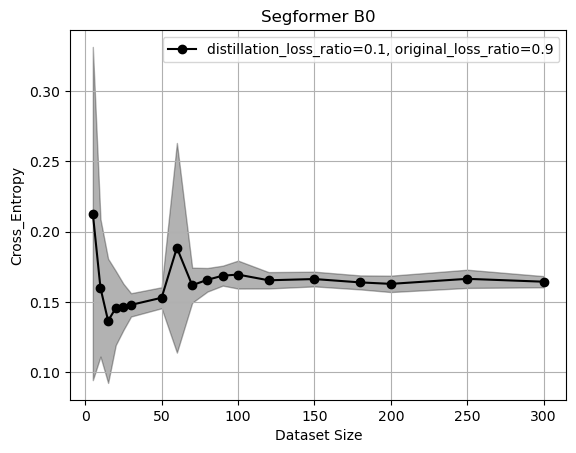

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()